# Wide and Deep Model for Movie Recommendation

<br>

A linear model with a wide set of crossed-column (co-occurrence) features can memorize the feature interactions, while deep neural networks (DNN) can generalize the feature patterns through low-dimensional dense embeddings learned for the sparse features. [**Wide-and-deep**](https://arxiv.org/abs/1606.07792) learning jointly trains wide linear model and deep neural networks to combine the benefits of memorization and generalization for recommender systems.

This notebook shows how to build and test the wide-and-deep model using [TensorFlow high-level Estimator API](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNLinearCombinedRegressor). With the [movie recommendation dataset](https://grouplens.org/datasets/movielens/), we quickly demonstrate following topics:
1. How to prepare data
2. Build the model
3. Use log-hook to estimate performance while training
4. Test the model and export

In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
import sys
sys.path.append("../../")
import itertools
import math
import os
from tempfile import TemporaryDirectory

import numpy as np
import scrapbook as sb
import pandas as pd
import sklearn.preprocessing
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # only show error messages

from reco_utils.common.constants import (
    DEFAULT_USER_COL as USER_COL,
    DEFAULT_ITEM_COL as ITEM_COL,
    DEFAULT_RATING_COL as RATING_COL,
    DEFAULT_PREDICTION_COL as PREDICT_COL,
    SEED
)
from reco_utils.common import tf_utils, gpu_utils, plot
from reco_utils.dataset import movielens
from reco_utils.dataset.pandas_df_utils import user_item_pairs
from reco_utils.dataset.python_splitters import python_random_split
import reco_utils.evaluation.python_evaluation as evaluator
import reco_utils.recommender.wide_deep.wide_deep_utils as wide_deep

print("Tensorflow Version:", tf.VERSION)
print("GPUs:\n", gpu_utils.get_gpu_info())

Tensorflow Version: 1.15.2
GPUs:
 []


In [7]:
"""Parameters (papermill)"""

# Recommend top k items
TOP_K = 10
# Select MovieLens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = '100k'
# Metrics to use for evaluation
RANKING_METRICS = [
    evaluator.ndcg_at_k.__name__,
    evaluator.precision_at_k.__name__,
]
RATING_METRICS = [
    evaluator.rmse.__name__,
    evaluator.mae.__name__,
]
# Use session hook to evaluate model while training
EVALUATE_WHILE_TRAINING = True
# Item feature column name
ITEM_FEAT_COL = 'genres'

RANDOM_SEED = SEED  # Set seed for deterministic result

# Train and test set pickle file paths. If provided, use them. Otherwise, download the MovieLens dataset.
DATA_DIR = None
TRAIN_PICKLE_PATH = None
TEST_PICKLE_PATH = None
EXPORT_DIR_BASE = './outputs/model'
# Model checkpoints directory. If None, use temp-dir.
MODEL_DIR='model_checkpoints'
#MODEL_DIR = None

#### Hyperparameters
MODEL_TYPE = 'wide_deep'
STEPS = 50000  # Number of batches to train
BATCH_SIZE = 32
# Wide (linear) model hyperparameters
LINEAR_OPTIMIZER = 'adagrad'
LINEAR_OPTIMIZER_LR = 0.0621  # Learning rate
LINEAR_L1_REG = 0.0           # Regularization rate for FtrlOptimizer
LINEAR_L2_REG = 0.0
LINEAR_MOMENTUM = 0.0         # Momentum for MomentumOptimizer or RMSPropOptimizer
# DNN model hyperparameters
DNN_OPTIMIZER = 'adadelta'
DNN_OPTIMIZER_LR = 0.1
DNN_L1_REG = 0.0           # Regularization rate for FtrlOptimizer
DNN_L2_REG = 0.0
DNN_MOMENTUM = 0.0         # Momentum for MomentumOptimizer or RMSPropOptimizer
# Layer dimensions. Defined as follows to make this notebook runnable from Hyperparameter tuning services like AzureML Hyperdrive
DNN_HIDDEN_LAYER_1 = 0     # Set 0 to not use this layer
DNN_HIDDEN_LAYER_2 = 64    # Set 0 to not use this layer
DNN_HIDDEN_LAYER_3 = 128   # Set 0 to not use this layer
DNN_HIDDEN_LAYER_4 = 512   # Note, at least one layer should have nodes.
DNN_HIDDEN_UNITS = [h for h in [DNN_HIDDEN_LAYER_1, DNN_HIDDEN_LAYER_2, DNN_HIDDEN_LAYER_3, DNN_HIDDEN_LAYER_4] if h > 0]
DNN_USER_DIM = 32          # User embedding feature dimension
DNN_ITEM_DIM = 16          # Item embedding feature dimension
DNN_DROPOUT = 0.8
DNN_BATCH_NORM = 1         # 1 to use batch normalization, 0 if not.

In [8]:
if MODEL_DIR is None:
    TMP_DIR = TemporaryDirectory()
    model_dir = TMP_DIR.name
else:
    if os.path.exists(MODEL_DIR) and os.listdir(MODEL_DIR):
        raise ValueError(
            "Model exists in {}. Use different directory name or "
            "remove the existing checkpoint files first".format(MODEL_DIR)
        )
    TMP_DIR = None
    model_dir = MODEL_DIR

In [9]:
model_dir

'model_checkpoints'

### 1. Prepare Data

#### 1.1 Movie Rating and Genres Data
First, download [MovieLens](https://grouplens.org/datasets/movielens/) data. Movies in the data set are tagged as one or more genres where there are total 19 genres including '*unknown*'. We load *movie genres* to use them as item features.

In [10]:
print (MOVIELENS_DATA_SIZE, USER_COL, ITEM_COL, RATING_COL, ITEM_FEAT_COL)

100k userID itemID rating genres


In [11]:
use_preset = (TRAIN_PICKLE_PATH is not None and TEST_PICKLE_PATH is not None)
if not use_preset:
    # The genres of each movie are returned as '|' separated string, e.g. "Animation|Children's|Comedy".
    data = movielens.load_pandas_df(
        size=MOVIELENS_DATA_SIZE,
        header=[USER_COL, ITEM_COL, RATING_COL],
        genres_col=ITEM_FEAT_COL
    )
    display(data.head())

100%|██████████| 4.81k/4.81k [00:01<00:00, 3.86kKB/s]


,userID,itemID,rating,genres
0,196,242,3.0,Comedy
1,63,242,3.0,Comedy
2,226,242,5.0,Comedy
3,154,242,3.0,Comedy
4,306,242,5.0,Comedy


In [12]:
print("Total {} items, {} users, {} rating, {} genres in the dataset".format(data['userID'].nunique(), data['itemID'].nunique(), data['rating'].nunique(), data['genres'].nunique() ))

Total 943 items, 1682 users, 5 rating, 216 genres in the dataset


#### 1.2 Encode Item Features (Genres)
To use genres from our model, we multi-hot-encode them with scikit-learn's [MultiLabelBinarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html).

For example, *Movie id=2355* has three genres, *Animation|Children's|Comedy*, which are being converted into an integer array of the indicator value for each genre like `[0, 0, 1, 1, 1, 0, 0, 0, ...]`. In the later step, we convert this into a float array and feed into the model.

> For faster feature encoding, you may load ratings and items separately (by using `movielens.load_item_df`), encode the item-features, then combine the rating and item dataframes by using join-operation. 

In [13]:
if not use_preset and ITEM_FEAT_COL is not None:
    # Encode 'genres' into int array (multi-hot representation) to use as item features
    genres_encoder = sklearn.preprocessing.MultiLabelBinarizer()
    data[ITEM_FEAT_COL] = genres_encoder.fit_transform(
        data[ITEM_FEAT_COL].apply(lambda s: s.split("|"))
    ).tolist()
    print("Genres:", genres_encoder.classes_)
    display(data.head())

Genres: ['Action' 'Adventure' 'Animation' "Children's" 'Comedy' 'Crime'
 'Documentary' 'Drama' 'Fantasy' 'Film-Noir' 'Horror' 'Musical' 'Mystery'
 'Romance' 'Sci-Fi' 'Thriller' 'War' 'Western' 'unknown']


,userID,itemID,rating,genres
0,196,242,3.0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,63,242,3.0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,226,242,5.0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,154,242,3.0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,306,242,5.0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


#### 1.3 Train and Test Split

In [14]:
if not use_preset:
    train, test = python_random_split(data, ratio=0.75, seed=RANDOM_SEED)
else:
    train = pd.read_pickle(path=TRAIN_PICKLE_PATH if DATA_DIR is None else os.path.join(DATA_DIR, TRAIN_PICKLE_PATH))
    test = pd.read_pickle(path=TEST_PICKLE_PATH if DATA_DIR is None else os.path.join(DATA_DIR, TEST_PICKLE_PATH))
    data = pd.concat([train, test])

print("{} train samples and {} test samples".format(len(train), len(test)))

75000 train samples and 25000 test samples


In [15]:
train.head(1)

,userID,itemID,rating,genres
98980,405,1305,1.0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [16]:
test.head(1)

,userID,itemID,rating,genres
75721,498,693,3.0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."


In [17]:
# Unique items in the dataset
if ITEM_FEAT_COL is None:
    items = data.drop_duplicates(ITEM_COL)[[ITEM_COL]].reset_index(drop=True)
    item_feat_shape = None
else:
    items = data.drop_duplicates(ITEM_COL)[[ITEM_COL, ITEM_FEAT_COL]].reset_index(drop=True)
    item_feat_shape = len(items[ITEM_FEAT_COL][0])
# Unique users in the dataset
users = data.drop_duplicates(USER_COL)[[USER_COL]].reset_index(drop=True)

print("Total {} items and {} users in the dataset".format(len(items), len(users)))

Total 1682 items and 943 users in the dataset


### 2. Build Model

Wide-and-deep model consists of a linear model and DNN. We use the following hyperparameters and feature sets for the model:

<br> | <div align="center">Wide (linear) model</div> | <div align="center">Deep neural networks</div>
---|---|---
Feature set | <ul><li>User-item co-occurrence features<br>to capture how their co-occurrence<br>correlates with the target rating</li></ul> | <ul><li>Deep, lower-dimensional embedding vectors<br>for every user and item</li><li>Item feature vector</li></ul>
Hyperparameters | <ul><li>FTRL optimizer</li><li>Learning rate = 0.0029</li><li>L1 regularization = 0.0</li></ul> | <ul><li>Adagrad optimizer</li><li>Learning rate = 0.1</li><li>Hidden units = [128, 256, 32]</li><li>Dropout rate = 0.4</li><li>Use batch normalization (Batch size = 64)</li><li>User embedding vector size = 4</li><li>Item embedding vector size = 4</li></ul>

<br>

* [FTRL optimizer](https://www.eecs.tufts.edu/~dsculley/papers/ad-click-prediction.pdf)
* [Adagrad optimizer](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)

The hyperparameters are already optimized for the training set. 

In [18]:
# Create model checkpoint every n steps. We store the model 5 times.
save_checkpoints_steps = max(1, STEPS // 5)

For both features, `user_ids` and `item_ids` were built using functions like `user_ids = tf.feature_column.categorical_column_with_vocabulary_list(user_col, users)`, then fed into tensorflow. 
For Wide features, two categorical columns for userID and itemID were fed in. The categorical vocabulary columns provide a way to represent strings as a one-hot vector. When data is provided to these columns, they will look like [0,1,0,0,.....], etc. The vocabulary were passed in through functions such as `    item_ids = tf.feature_column.categorical_column_with_vocabulary_list(item_col, items)`

crossed_feat_dim(1000) is used for the bucket size of the cross features. So instead of having the full, huge table or cross product of features, it will be limited by the bucket size

the embedding features convert the categorigal columns into embedding spaces with predefined dimentions. Remember that DNN_USER_DIM = 32; DNN_ITEM_DIM = 16

In [19]:
# Define wide (linear) and deep (dnn) features
wide_columns, deep_columns = wide_deep.build_feature_columns(
    users=users[USER_COL].values,
    items=items[ITEM_COL].values,
    user_col=USER_COL,
    item_col=ITEM_COL,
    item_feat_col=ITEM_FEAT_COL,
    crossed_feat_dim=1000,
    user_dim=DNN_USER_DIM,
    item_dim=DNN_ITEM_DIM,
    item_feat_shape=item_feat_shape,
    model_type=MODEL_TYPE,
)

print("Wide feature specs:")
for c in wide_columns:
    print("\t", str(c)[:100], "...")
print("Deep feature specs:")
for c in deep_columns:
    print("\t", str(c)[:100], "...")

Wide feature specs:
	 VocabularyListCategoricalColumn(key='userID', vocabulary_list=(196, 63, 226, 154, 306, 296, 34, 271, ...
	 VocabularyListCategoricalColumn(key='itemID', vocabulary_list=(242, 302, 377, 51, 346, 474, 265, 465 ...
	 CrossedColumn(keys=(VocabularyListCategoricalColumn(key='userID', vocabulary_list=(196, 63, 226, 154 ...
Deep feature specs:
	 EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='userID', vocabulary_list=(19 ...
	 EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='itemID', vocabulary_list=(24 ...
	 NumericColumn(key='genres', shape=(19,), default_value=None, dtype=tf.float32, normalizer_fn=None) ...


The following function applies tensorflow's `LinearRegressor` or `DNNRegressor` or `DNNLinearCombinedRegressor` , depending on the combination of `wide_columns` and `deep_columns`

In [20]:
# Build a model based on the parameters
model = wide_deep.build_model(
    model_dir=model_dir,
    wide_columns=wide_columns,
    deep_columns=deep_columns,
    linear_optimizer=tf_utils.build_optimizer(LINEAR_OPTIMIZER, LINEAR_OPTIMIZER_LR, **{
        'l1_regularization_strength': LINEAR_L1_REG,
        'l2_regularization_strength': LINEAR_L2_REG,
        'momentum': LINEAR_MOMENTUM,
    }),
    dnn_optimizer=tf_utils.build_optimizer(DNN_OPTIMIZER, DNN_OPTIMIZER_LR, **{
        'l1_regularization_strength': DNN_L1_REG,
        'l2_regularization_strength': DNN_L2_REG,
        'momentum': DNN_MOMENTUM,  
    }),
    dnn_hidden_units=DNN_HIDDEN_UNITS,
    dnn_dropout=DNN_DROPOUT,
    dnn_batch_norm=(DNN_BATCH_NORM==1),
    log_every_n_iter=max(1, STEPS//10),  # log 10 times
    save_checkpoints_steps=save_checkpoints_steps,
    seed=RANDOM_SEED
)

### 3. Train and Evaluate Model

Now we are all set to train the model. Here, we show how to utilize session hooks to track model performance while training. Our custom hook `tf_utils.evaluation_log_hook` estimates the model performance on the given data based on the specified evaluation functions. Note we pass test set to evaluate the model on rating metrics while we use <span id="ranking-pool">ranking-pool (all the user-item pairs)</span> for ranking metrics.

> Note: The TensorFlow Estimator's default loss calculates Mean Squared Error. Square root of the loss is the same as [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation).

In [21]:
print (USER_COL, ITEM_COL, RATING_COL, PREDICT_COL, RANDOM_SEED)

userID itemID rating prediction 42


In [22]:
cols = {
    'col_user': USER_COL,
    'col_item': ITEM_COL,
    'col_rating': RATING_COL,
    'col_prediction': PREDICT_COL,
}

# Prepare ranking evaluation set, i.e. get the cross join of all user-item pairs
ranking_pool = user_item_pairs(
    user_df=users,
    item_df=items,
    user_col=USER_COL,
    item_col=ITEM_COL,
    user_item_filter_df=train,  # Remove seen items
    shuffle=True,
    seed=RANDOM_SEED
)

ranking_pool returns a DataFrame, with all pairs of user-item from user_df and item_df, excepting the pairs in user_item_filter_df

In [23]:
print("Total {} items, {} users in the dataset".format(data['userID'].nunique(), data['itemID'].nunique() ))
print ("Training set has {} pairs".format(train.shape[0]))
print ("So the ranking pool should have {} amount of pairs".format(943*1682 - 75000))
print ("Which is exactly right: {}".format(ranking_pool.shape[0]))
ranking_pool.head()

Total 943 items, 1682 users in the dataset
Training set has 75000 pairs
So the ranking pool should have 1511126 amount of pairs
Which is exactly right: 1511126


,userID,itemID,genres
0,626,1422,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
1,818,219,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
2,75,1639,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
3,352,1491,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
4,68,1639,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."


The `evaluation_log_hook` returns a `tf.train.SessionRunHook` session run hook to evaluate the model while training. See the source code of `tf_utils` for details

In [24]:
# Define training hooks to track performance while training
hooks = []
if EVALUATE_WHILE_TRAINING:
    evaluation_logger = tf_utils.MetricsLogger()
    for metrics in (RANKING_METRICS, RATING_METRICS):
        if len(metrics) > 0:
            hooks.append(
                tf_utils.evaluation_log_hook(
                    model,
                    logger=evaluation_logger,
                    true_df=test,
                    y_col=RATING_COL,
                    eval_df=ranking_pool if metrics==RANKING_METRICS else test.drop(RATING_COL, axis=1),
                    every_n_iter=save_checkpoints_steps,
                    model_dir=model_dir,
                    eval_fns=[evaluator.metrics[m] for m in metrics],
                    **({**cols, 'k': TOP_K} if metrics==RANKING_METRICS else cols)
                )
            )

# Define training input (sample feeding) function
train_fn = tf_utils.pandas_input_fn(
    df=train,
    y_col=RATING_COL,
    batch_size=BATCH_SIZE,
    num_epochs=None,  # We use steps=TRAIN_STEPS instead.
    shuffle=True,
    seed=RANDOM_SEED,
)

In [25]:
print(
    "Training steps = {}, Batch size = {} (num epochs = {})"
    .format(STEPS, BATCH_SIZE, (STEPS*BATCH_SIZE)//len(train))
)
tf.logging.set_verbosity(tf.logging.INFO)

try:
    model.train(
        input_fn=train_fn,
        hooks=hooks,
        steps=STEPS
    )
except tf.train.NanLossDuringTrainingError:
    import warnings
    warnings.warn(
        "Training stopped with NanLossDuringTrainingError. "
        "Try other optimizers, smaller batch size and/or smaller learning rate."
    )

Training steps = 50000, Batch size = 32 (num epochs = 21)
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Calling model_fn.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorf

Evaluation logger logs the following evaluation metrics while training and we can plot them out against the training steps

In [26]:
print (RANKING_METRICS, RATING_METRICS)


['ndcg_at_k', 'precision_at_k'] ['rmse', 'mae']


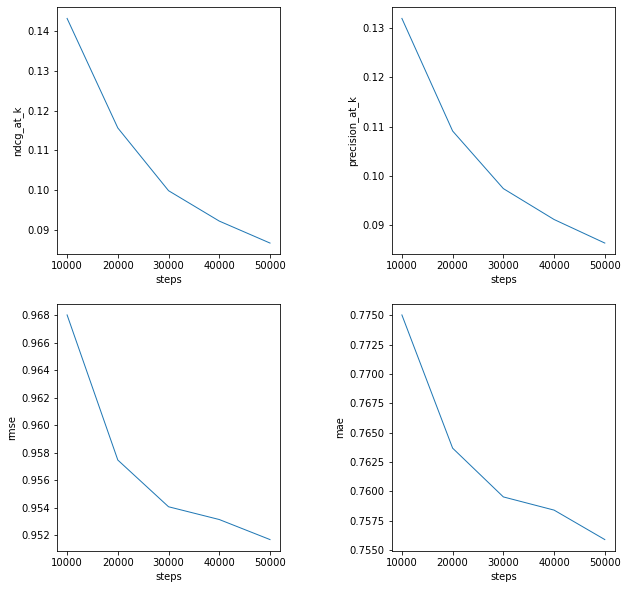

In [27]:
if EVALUATE_WHILE_TRAINING:
    logs = evaluation_logger.get_log()
    for i, (m, v) in enumerate(logs.items(), 1):
        sb.glue("eval_{}".format(m), v)
        x = [save_checkpoints_steps*i for i in range(1, len(v)+1)]
        plot.line_graph(
            values=list(zip(v, x)),
            labels=m,
            x_name="steps",
            y_name=m,
            subplot=(math.ceil(len(logs)/2), 2, i),
        )

#### 3.2 TensorBoard

Once the train is done, you can browse the details of the training results as well as the metrics we logged from [TensorBoard](https://www.tensorflow.org/guide/summaries_and_tensorboard).

[]()|[]()|[]()
:---:|:---:|:---:
<img src="https://recodatasets.z20.web.core.windows.net/images/tensorboard_0.png?sanitize=true"> |  <img src="https://recodatasets.z20.web.core.windows.net/images/tensorboard_1.png?sanitize=true"> | <img src="https://recodatasets.z20.web.core.windows.net/images/tensorboard_2.png?sanitize=true">

To open the TensorBoard, open a terminal from the same directory of this notebook, run `tensorboard --logdir=model_checkpoints`, and open http://localhost:6006 from a browser.



### 4. Test and Export Model

#### 4.1 Item rating prediction

In [28]:
if len(RATING_METRICS) > 0:
    predictions = list(model.predict(input_fn=tf_utils.pandas_input_fn(df=test)))
    prediction_df = test.drop(RATING_COL, axis=1)
    prediction_df[PREDICT_COL] = [p['predictions'][0] for p in predictions]
    
    rating_results = {}
    for m in RATING_METRICS:
        result = evaluator.metrics[m](test, prediction_df, **cols)
        sb.glue(m, result)
        rating_results[m] = result
    print(rating_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from model_checkpoints/model.ckpt-50000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


{'rmse': 0.9516880267079603, 'mae': 0.7558849908959866}


#### 4.2 Recommend k items
For top-k recommendation evaluation, we use the ranking pool (all the user-item pairs) we prepared at the [training step](#ranking-pool). The difference is we remove users' seen items from the pool in this step which is more natural to the movie recommendation scenario.

In [29]:
if len(RANKING_METRICS) > 0:
    predictions = list(model.predict(input_fn=tf_utils.pandas_input_fn(df=ranking_pool)))
    prediction_df = ranking_pool.copy()
    prediction_df[PREDICT_COL] = [p['predictions'][0] for p in predictions]

    ranking_results = {}
    for m in RANKING_METRICS:
        result = evaluator.metrics[m](test, prediction_df, **{**cols, 'k': TOP_K})
        sb.glue(m, result)
        ranking_results[m] = result
    print(ranking_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from model_checkpoints/model.ckpt-50000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


{'ndcg_at_k': 0.08662186218122483, 'precision_at_k': 0.08642629904559916}


#### 4.3 Export Model
Finally, we export the model so that we can load later for re-training, evaluation, and prediction.

In [30]:
os.makedirs(EXPORT_DIR_BASE, exist_ok=True)

In [31]:
exported_path = tf_utils.export_model(
    model=model,
    train_input_fn=train_fn,
    eval_input_fn=tf_utils.pandas_input_fn(
        df=test, y_col=RATING_COL
    ),
    tf_feat_cols=wide_columns+deep_columns,
    base_dir=EXPORT_DIR_BASE
)
sb.glue('saved_model_dir', str(exported_path))
print("Model exported to", str(exported_path))

Model exported to ./outputs/model/1613871669


In [32]:
# Close the event file so that the model folder can be cleaned up.
summary_writer = tf.summary.FileWriterCache.get(model.model_dir)
summary_writer.close()

# Cleanup temporary directory if used
if TMP_DIR is not None:
    TMP_DIR.cleanup()

<i>Modified by Xiaohan Zhang, based on the original version of </i>

<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>